<a href="https://colab.research.google.com/github/ishaqmarashy/Titanic-ML/blob/main/SGD_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [333]:
raw_train_url = "https://raw.githubusercontent.com/ishaqmarashy/Titanic-ML/main/train.csv"
raw_test_url = "https://raw.githubusercontent.com/ishaqmarashy/Titanic-ML/main/test.csv"
def load_data(url):
  # download the csv file from github
  download = requests.get(url).content
  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False)
  return df

In [334]:
train_df = load_data(raw_train_url)
test_df = load_data(raw_test_url)
train_df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [335]:
# Some data is missing but we only require age from the missing values
# Drop the irrelevant data 'Name','Cabin','Ticket','Embarked'
def process(df):
  df['Sex'] = (df['Sex'] == 'female').astype(int)
  df['Age'].fillna(value=df['Age'].mean(), inplace=True)
  df['Fare'].fillna(value=df['Fare'].mean(), inplace=True)
  if df.columns.isin(['Name','Cabin','Ticket','Embarked']).any():
    df=df.drop(columns=['Name','Cabin','Ticket','Embarked'])
  # We know age and sex played an important role in the survival of the sinking titanic
  # We can use that to engineer a new feature
  df['S&A']=(df['Sex']+1)*df['Age'] 
  return df
train_df=process(train_df)
test_df=process(test_df)
train_df.info() 
test_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   S&A       891 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 62.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    418 non-null    float64
 6   S&A     418 non-null    float64
dtypes: float64

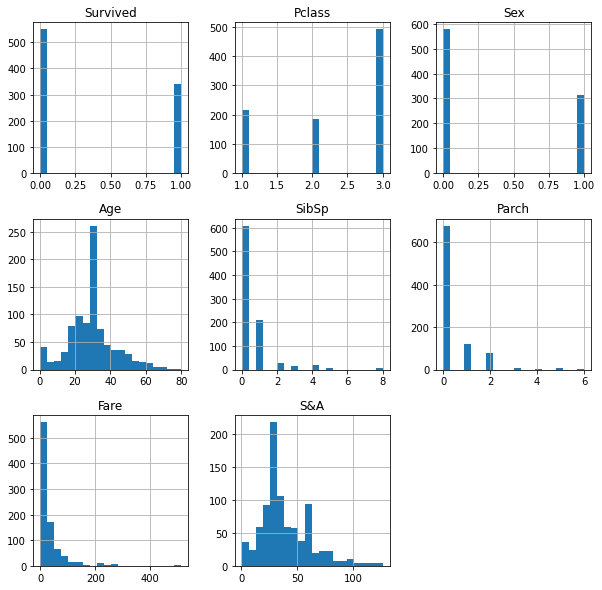

In [336]:
train_df.describe()
train_df.hist(bins=20, figsize=(10,10))
plt.show()

In [337]:

corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)
#suggests strong correlation between fare and surviving  
#negative correlation with ticket class however that may be due to lower number of tickets in the higher class

Survived    1.000000
Sex         0.543351
S&A         0.306594
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.069809
Pclass     -0.338481
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fada39f63a0>,
      dtype=object)

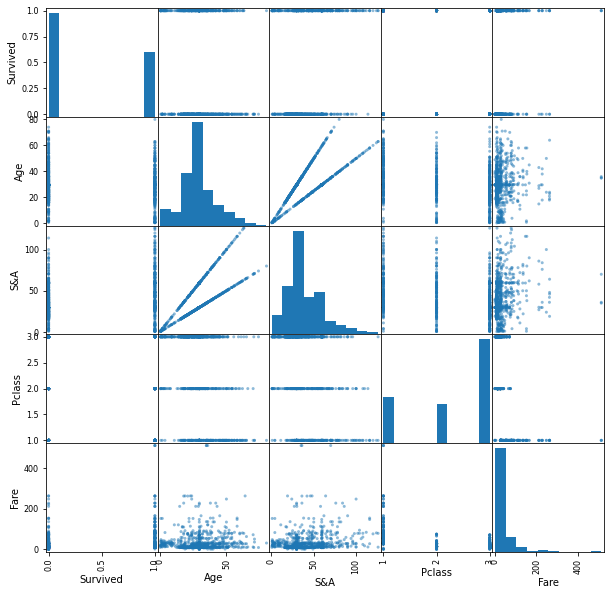

In [338]:
from pandas.plotting import scatter_matrix
plotted_features=['Survived','Age','S&A','Pclass','Fare']
scatter_matrix(train_df[plotted_features], figsize=(10, 10))


In [339]:
# y contains the class I am trying to predict. In this case its survivability
y=train_df['Survived']
X=train_df.drop(columns=['Survived'])
X_Pred=test_df
# 70% of the training data is being kept seperate to evaluate the model
# 30% goes in Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [340]:
# Runs gradient descent to train the model 
from sklearn.linear_model import SGDClassifier
# Tels the model to do 1000 training loops when sgd classifier is fit
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# Fits the model to the X values to predict Y values finding the optimal weights and bias for the mode accurate predictions
sgd_clf.fit(X_train, y_train)
y_pred=sgd_clf.predict(X_test)

In [341]:
# Metrics on how the data deals with the test set
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
# TP|FP
# FN|TN 
cm=confusion_matrix(y_train, y_train_pred)
print(f"True Positive {cm[0][0]} | False Positive {cm[0][1]} \nFalse Negative {cm[1][0]} | True Negative {cm[1][1]} ")
print(classification_report(y_test, y_pred))


True Positive 262 | False Positive 129 
False Negative 120 | True Negative 112 
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       158
           1       0.82      0.13      0.22       110

    accuracy                           0.63       268
   macro avg       0.72      0.55      0.49       268
weighted avg       0.70      0.63      0.54       268



In [342]:
y_pred_test=sgd_clf.predict(X_Pred)
X_Pred['Survived']=y_pred_test
y_pred_test_df=X_Pred['Survived']
y_pred_test_df.to_csv('submission.csv', index=False)